# Syntax
Let's define the abstract syntax tree (AST) of Untyped Arithmetic Expressions
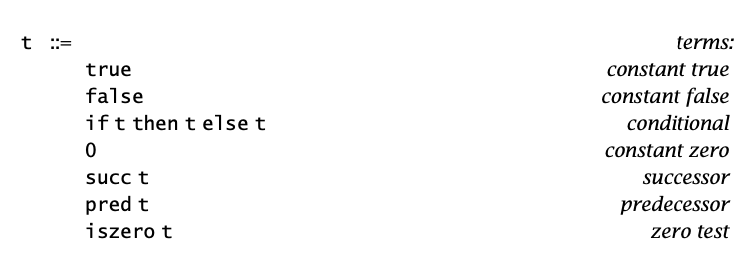

In [1]:
data Term
    = True
    | False
    | IfThenElse Term Term Term
    | Zero
    | Succ Term
    | Pred Term
    | IsZero Term
    deriving (Show, Eq)

The program `if true then (succ 0) else 0` can be represented as below.

In [2]:
IfThenElse True (Succ Zero) Zero

IfThenElse True (Succ Zero) Zero

Define the `consts` function
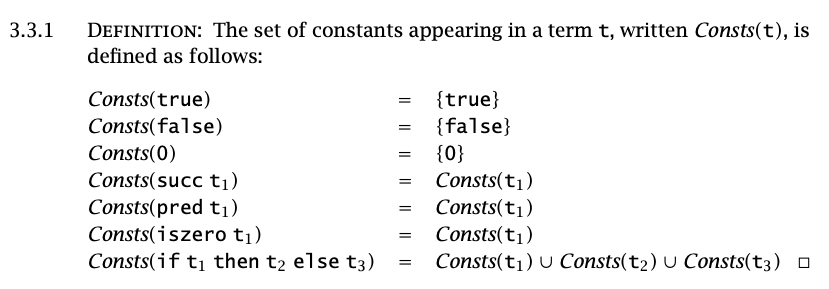

In [3]:
import Data.List
consts :: Term -> [Term]
consts True = [True]
consts False = [False]
consts Zero = [Zero]
consts (Succ t) = consts t
consts (Pred t) = consts t
consts (IsZero t) = consts t
consts (IfThenElse t1 t2 t3) = consts t1 `union` consts t2 `union` consts t3

In [4]:
consts $ IfThenElse True (Succ Zero) Zero

[True,Zero]

Define the `size` function
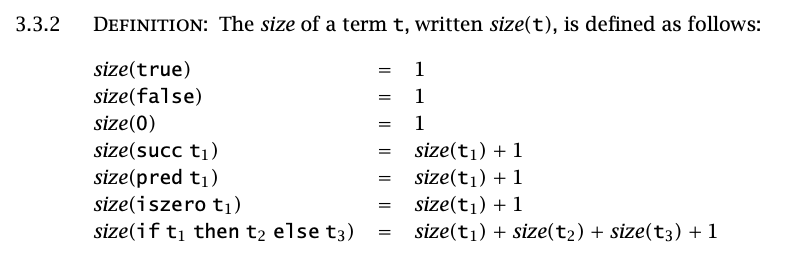

In [5]:
size :: Term -> Int
size True = 1
size False = 1
size Zero = 1
size (Succ t) = size t + 1
size (Pred t) = size t + 1
size (IsZero t) = size t + 1
size (IfThenElse t1 t2 t3) = size t1 + size t2 + size t3 + 1

In [6]:
size $ IfThenElse True (Succ Zero) Zero

5

Define the `depth` function.
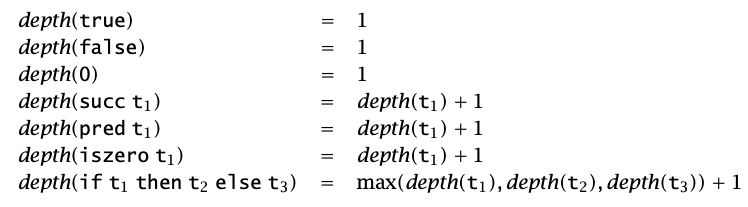

In [7]:
depth :: Term -> Int
depth True = 1
depth False = 1
depth Zero = 1
depth (Succ t) = depth t + 1
depth (Pred t) = depth t + 1
depth (IsZero t) = depth t + 1
depth (IfThenElse t1 t2 t3) = maximum [depth t1, depth t2, depth t3] + 1

In [8]:
depth $ IfThenElse True (Succ Zero) Zero

3

Check the lemma using QuickCheck.
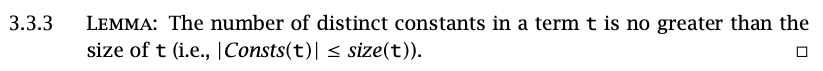

In [9]:
import Test.QuickCheck

prop_n_of_consts_no_greater_than_size t = collect (size t) $ (length . consts) t <= size t

quickCheck prop_n_of_consts_no_greater_than_size

: 

`Term` is not an instance of `Arbitrary` so we need to define that.
Refer to [QuickCheck manual](https://www.cse.chalmers.se/~rjmh/QuickCheck/manual.html) for further details.

In [10]:
instance Arbitrary Term where
    arbitrary = sized term
        where term 0 = elements [True, False, Zero]
              term n = frequency [
                    (1, return True),
                    (1, return False),
                    (1, return Zero),
                    (3, Succ <$> term (n - 1)),
                    (3, Pred <$> term (n - 1)),
                    (3, IsZero <$> term (n - 1)),
                    (3, IfThenElse <$> term (n `div` 3) <*> term (n `div` 3) <*> term (n `div` 3))
                ]

Now we can see that all test passes

In [11]:
quickCheck prop_n_of_consts_no_greater_than_size

+++ OK, passed 100 tests:
19% 1
13% 2
 8% 4
 6% 3
 5% 5
 3% 33
 3% 6
 2% 12
 2% 18
 2% 22
 2% 34
 2% 44
 2% 46
 2% 47
 2% 52
 2% 61
 2% 8
 1% 10
 1% 13
 1% 14
 1% 17
 1% 19
 1% 25
 1% 26
 1% 28
 1% 29
 1% 30
 1% 35
 1% 37
 1% 38
 1% 41
 1% 42
 1% 48
 1% 49
 1% 58
 1% 59
 1% 63
 1% 64
 1% 68
 1% 9

# Semantics
Small-step operational semantics
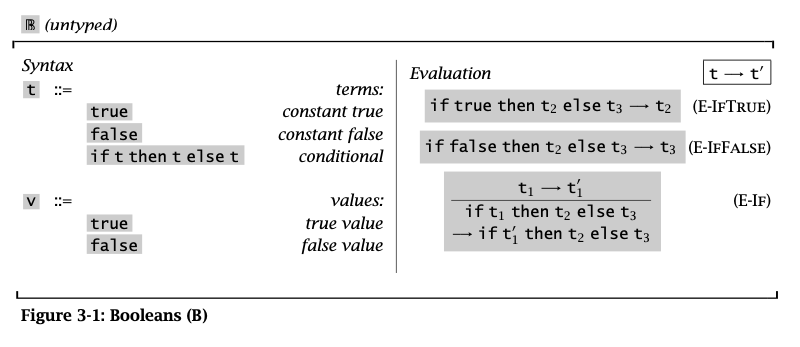
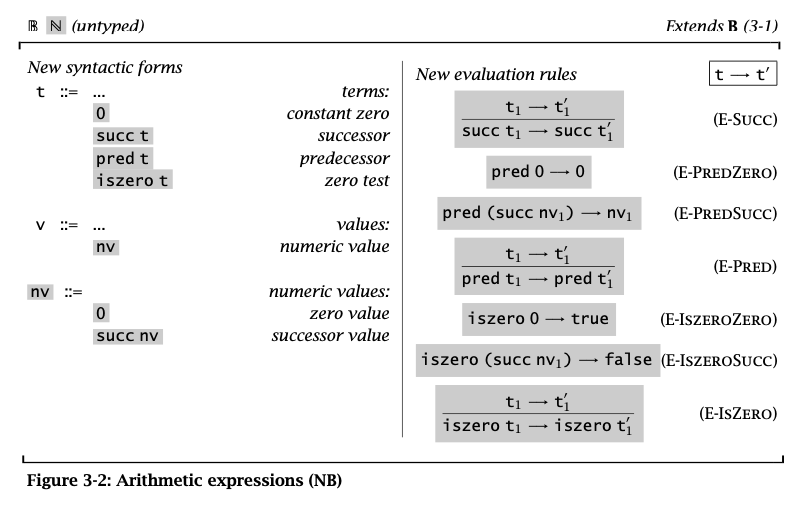

In [12]:
isNumeric Zero = Prelude.True
isNumeric (Succ t) | isNumeric t = Prelude.True
isNumeric _ = Prelude.False

-- Same as `isValue t = t == True || t == False || isNumeric t`
isValue = or . sequenceA [(== True), (== False), isNumeric]

-- Nothing represents "stuck"/"error" status
smallEval :: Term -> Maybe Term
smallEval t | isValue t = return t
smallEval t = do
    t' <- step t
    smallEval t'
    
step :: Term -> Maybe Term
step (IfThenElse True t2 t3) = return t2
step (IfThenElse False t2 t3) = return t3
step (IfThenElse t1 t2 t3) = do
    t1' <- step t1
    return $ IfThenElse t1' t2 t3
step (Succ t) = do
    t' <- step t
    return $ Succ t'
step (Pred Zero) = return Zero
step (Pred (Succ nv)) | isNumeric nv = return nv
step (Pred t) = do
    t' <- step t
    return $ Pred t'
step (IsZero Zero) = return True
step (IsZero (Succ nv)) | isNumeric nv = return False
step (IsZero t) = do
    t' <- step t
    return $ IsZero t'
step _ = Nothing

Illustrate this example
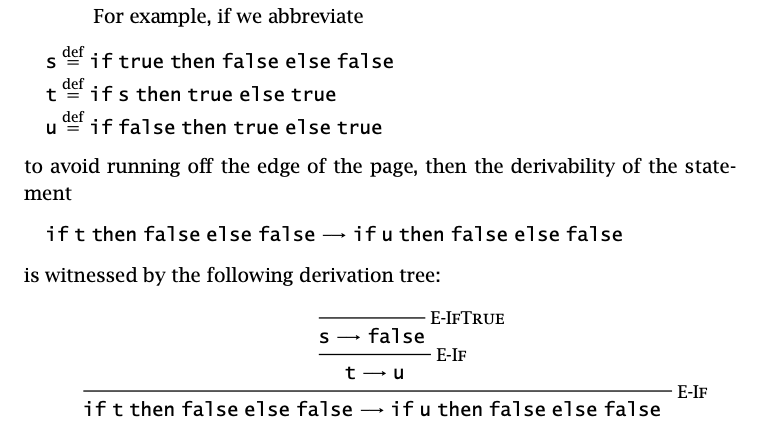

In [13]:
s = IfThenElse True False False
t = IfThenElse s True True
u = IfThenElse False True True
step (IfThenElse t False False) == Just (IfThenElse u False False)

True

Next, define big-step evaluation.
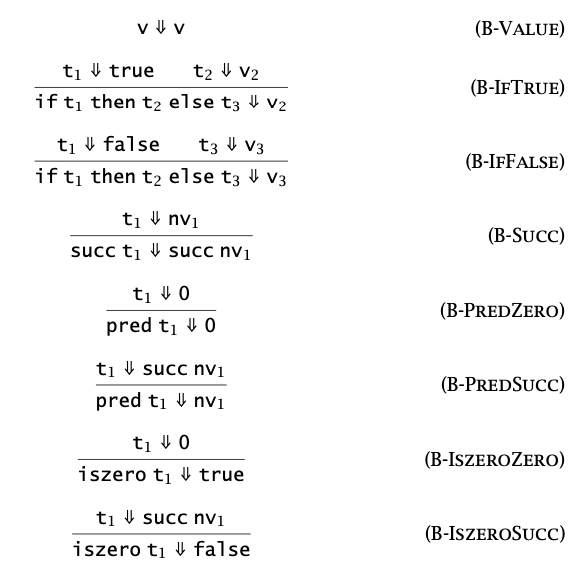

In [14]:
bigEval :: Term -> Maybe Term
bigEval v | isValue v = return v
bigEval (IfThenElse t1 t2 t3)
    | Just True <- bigEval t1 = bigEval t2
    | Just False <- bigEval t1 = bigEval t3
bigEval (Succ t)
    | Just t' <- bigEval t, isNumeric t' = return $ Succ t'
bigEval (Pred t)
    | Just Zero <- bigEval t = return Zero
    | Just (Succ nv) <- bigEval t = return nv
bigEval (IsZero t)
    | Just Zero <- bigEval t = return True
    | Just (Succ nv) <- bigEval t = return False
bigEval _ = Nothing

In [15]:
bigEval (IfThenElse (IsZero (Succ Zero)) Zero (Succ Zero))

Just (Succ Zero)

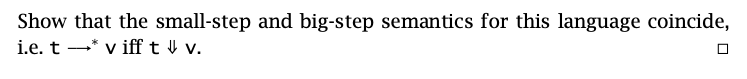

In [16]:
import Data.Maybe

prop_small_big_equiv t =
    classify (isNothing smallResult) "invalid term" $
    smallResult === bigResult
    where smallResult = smallEval t
          bigResult = bigEval t

quickCheckWith stdArgs{maxSuccess=1000} prop_small_big_equiv

+++ OK, passed 1000 tests (71.2% invalid term).